# Sentiment Analysis with Xgboost

Predict the `score` assigned with each text amazon fine food reviews using xgboost.

### Libraries

In [88]:
import sys
!{sys.executable} -m pip install wordcloud
!{sys.executable} -m pip install xgboost

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # colorful plots
from collections import Counter
import xgboost as xgb
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score #evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from time import time #check runtime



twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dena1\AppData\Roaming\nltk_data...


twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dena1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load Data

In [89]:
#--------------------------------------------------------------------------------
# Constants and Configurations

DATA_LOCAL = True
LOCAL_PATH = "../data/"
REMOTE_PATH = "https://s3.amazonaws.com/coetichr/AmazonFoodReviews/"
NROWS = 10000 #edit with a smaller size to develop faster
TOKENIZER = RegexpTokenizer(r'\w+') #no punctuation
STEMMER = nltk.PorterStemmer()
STOPWORD_CORPUS = stopwords.words("english")
sns.set(style="whitegrid", context="paper") #looks nicer with a blank background

# TODO: Seperate this into a seperate file/ library so we can load it into all the scripts
def load_data(file):
    path = LOCAL_PATH if DATA_LOCAL else REMOTE_PATH
    return pd.read_csv(path + file, nrows=NROWS)


# Load Reviews.csv
reviewsdf = load_data("Reviews.csv")

#drop columns not needed
reviewsdf.drop(columns=["ProductId", "UserId", "ProfileName", "Time", "Summary", "HelpfulnessDenominator", "HelpfulnessNumerator"], inplace=True, axis=1)
reviewsdf.dropna(inplace=True) #drop empty fields
reviewsdf['Positivity'] = np.where(reviewsdf['Score'] > 3, 1, 0)

print("Shape: ", reviewsdf.shape)
print(reviewsdf.head())


Shape:  (568454, 4)
   Id  Score                                               Text  Positivity
0   1      5  I have bought several of the Vitality canned d...           1
1   2      1  Product arrived labeled as Jumbo Salted Peanut...           0
2   3      4  This is a confection that has been around a fe...           1
3   4      2  If you are looking for the secret ingredient i...           0
4   5      5  Great taffy at a great price.  There was a wid...           1


### Analysis

Look at the distribution of different scores and words received for each text review.

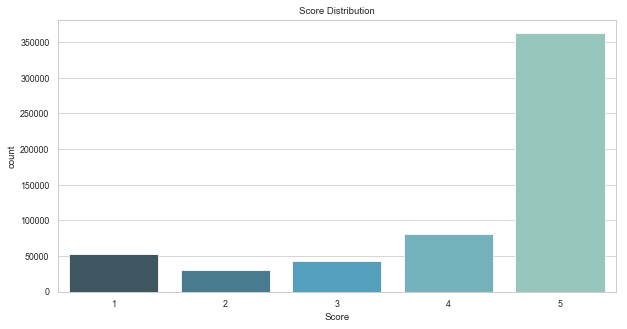

In [90]:

class QuickPlot:
    def __init__(self, title=""):
        self.title = title;
        
    # df is a hash with word:freq mappings
    def wordcloud(self, df):
        wordcloud = WordCloud(
            width=1400,
            height=600,
            background_color="white",
            colormap="Dark2",
            max_words=50,
            mode="RGBA").generate_from_frequencies(df)
        # make figure to plot
        plt.figure( figsize=(10,5))
        # plot words
        plt.imshow(wordcloud, interpolation="bilinear")
        # remove axes
        plt.axis("off")
        # show the result
        plt.show()
        
    def plot_confusion_matrix(xtest, ytest, preds):
        cm = confusion_matrix(ytest, preds)
        score = model.score(xtest, ytest)
        plt.figure(figsize = (9,9))
        sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = 'Blues_r')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        title = 'Accuracy Score: {0}'.format(score)
        plt.title(title, size = 15)
        plt.show()
        
    def barplot(self, df):
        plt.subplots(figsize = (15,10))
        sns.barplot(x = df['count'], y = df['token'], palette = "deep").set_title(self.title)
        plt.show() 
        
    def countplot(self, df, xcol):
        sns.countplot(x=xcol, data=df, palette="GnBu_d").set_title(self.title)
        plt.show()
        
#view distribution of scores
plt.subplots(figsize=(10,5))
QuickPlot("Score Distribution").countplot(reviewsdf, "Score")

#view top words for each score
#sum_words = bow.sum(axis=0) 
#words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
#words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

#word_freq_dict = {}
#for a, b in words_freq: 
#    word_freq_dict[a] = float(b)
#QuickPlot().wordcloud(word_freq_dict)

#words_freq_df = pd.DataFrame(word_freq_dict.items(),index=word_freq_dict.keys(), columns=["token", "count"])
#QuickPlot("Top 25 words in reviews").barplot(words_freq_df)

### Data Preprocessing

Going to tokenize the words and anything that might need to be removed (stopwords, puncutation, etc), apply stemming where the root of the word is extracted from the sentence, and create a bag of words model. BoW representation specifies the occurrence of tokens in the whole corpus.

In [ ]:
# parse the text into tokens and apply to the table, along with stemming
def tokenizefn(row):
    rownew = TOKENIZER.tokenize(row) #tokenize    
    #stem
    rownew = list(map(lambda str: STEMMER.stem(str), rownew))
    return rownew

X_train, X_test, Y_train, Y_test = train_test_split(reviewsdf["Text"], reviewsdf['Positivity'], random_state = 0)

#build BoW
vectorizer = CountVectorizer(
ngram_range = (1,3),
analyzer = 'word',
tokenizer=tokenizefn,
lowercase=False,
min_df=10
).fit(X_train)

bow = vectorizer.transform(X_train)

print("Number of features: " + str(len(vectorizer.get_feature_names())))
print('X_train row count: ', X_train.shape[0])
print('Y_train row count: ', Y_train.shape[0])

### Model Training

In [ ]:

def test_classifier(X_train, y_train, X_test, y_test, classifier):
    print("")
    print("===============================================")
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    print("Predicting time {0}s".format(time() - now))

    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    print("=================== Results ===================")
    print("            Negative     Neutral     Positive")
    print("F1       " + str(f1))
    print("Precision" + str(precision))
    print("Recall   " + str(recall))
    print("Accuracy " + str(accuracy))
    print("===============================================")

    return precision, recall, accuracy, f1

test_classifier(
    vectorizer.transform(X_train),
    Y_train,
    vectorizer.transform(X_test),
    Y_test,
    LogisticRegression())

test_classifier(
    vectorizer.transform(X_train),
    Y_train,
    vectorizer.transform(X_test),
    Y_test,
    xgb.XGBClassifier(
        silent=True,
        max_depth=100,
        n_estimators=100
    ))


### Results